<a href="https://colab.research.google.com/github/Br-alexis73/Face_recognition/blob/master/fr_experiment_alexnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'lfw-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F26922%2F34595%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240419%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240419T152011Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Db4ec61946419ca8b830a0f4613cac81dffb050d7d712972d73e73a8d24cc40a231fb1a47a2c7bce99a68ff93e9ac40d5a337ede5b14e8940c63ba216337c90b4cc432075b2f24e158971a25f9ecb52e84512e1cdc8473afcdfc20275099542b8cc23208d379bed1a7e644e96a929b7dbb91a7019f5331c94ea9f46d05bdd60badb9169961ed1faa90ae1290e3919c42a5736aa4fd68b941df0dac0e6957e4528a6663da154303292f0925fe7bc92d10ad202845647f7a1eff66f586604bb52c0626b2d95f3daf452d5dae6be3e0f2daf1e3177513be89acda9a7114a083009f77cf36a5edd56f41bb1bf1ba424974542d3b8bd7ac3ec5ab7122a096e033e4df9'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 117895655 bytes downloaded
Downloaded and uncompressed: lfw-dataset
Data source import complete.


In [2]:
!pip install mtcnn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 6.6 MB/s eta 0:00:00


In [3]:
from mtcnn.mtcnn import MTCNN
from PIL import Image
from numpy import asarray
# Function to extract a single face from a given photograph
def extract_face(filename, required_size=(250, 250)):
    # Load image from file
    image = Image.open(filename)
    # Convert to RGB, if needed
    image = image.convert('RGB')
    # Convert to array
    pixels = asarray(image)
    # Create the detector, using default weights
    detector = MTCNN()
    # Detect faces in the image
    results = detector.detect_faces(pixels)
    # If no faces are detected, return None or handle it as needed
    if len(results) == 0:
        return None
    # Extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    # Bug fix - sometimes the detector returns negative coordinates
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    # Extract the face
    face = pixels[y1:y2, x1:x2]
    # Resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = asarray(image)
    return face_array


In [4]:
def load_faces(directory):
    faces = []
    # Enumerate files
    for filename in os.listdir(directory):
        # Path
        path = directory + filename
        # Get face
        face = extract_face(path)
        if face is not None:
            faces.append(face)
    return faces

In [5]:
def load_dataset(directory):
    X, y = list(), list()
    # Enumerate folders, on per class
    for subdir in os.listdir(directory):
        # Path
        path = directory + subdir + '/'
        # Skip any files that might be in the dir
        if not os.path.isdir(path):
            continue
        # Load all faces in the subdirectory
        faces = load_faces(path)
        # Create labels
        labels = [subdir for _ in range(len(faces))]
        # Summarize progress
        print('Loaded %d examples for class: %s' % (len(faces), subdir))
        # Store
        X.extend(faces)
        y.extend(labels)
    return asarray(X), asarray(y)

In [6]:
import os
import pandas as pd

dataset_path = '../input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled'

# Generate a list of (name, image count) tuples
names_images = []

for name in os.listdir(dataset_path):
    directory = os.path.join(dataset_path, name)
    if os.path.isdir(directory):
        image_count = len([i for i in os.listdir(directory) if i.endswith('.jpg')])
        if image_count >= 20:  # Check if the count is 10 or more
            names_images.append((name, image_count))

# Count the number of people with 10 or more images
number_of_people = len(names_images)
print(f"Number of people with 20 or more images: {number_of_people}")

# Create a DataFrame
lfw_allnames = pd.DataFrame(names_images, columns=['name', 'images'])

# Save the DataFrame to a CSV file
lfw_csv_path = '../input/lfw-dataset/lfw_allnames.csv'
lfw_allnames.to_csv(lfw_csv_path, index=False)

print(f"CSV file created at: {lfw_csv_path}")

Number of people with 20 or more images: 62
CSV file created at: ../input/lfw-dataset/lfw_allnames.csv


In [7]:
import os
import shutil
import pandas as pd

# Define the path to the dataset and the new directory
dataset_path = '../input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled'
new_dir_path = '../lfw-data-experiment'
csv_path = '../input/lfw-dataset/lfw_allnames.csv'

# Read the CSV file to get the list of names
all_names_df = pd.read_csv(csv_path)
names_list = all_names_df['name'].tolist()

# Create the new directory if it doesn't exist
if not os.path.exists(new_dir_path):
    os.makedirs(new_dir_path)

# Move the folders
for name in names_list:
    source_folder = os.path.join(dataset_path, name)
    destination_folder = os.path.join(new_dir_path, name)

    # Check if the destination folder already exists
    if os.path.exists(destination_folder):
        # Remove the existing folder
        shutil.rmtree(destination_folder)

    # Check if the source folder exists before moving
    if os.path.exists(source_folder):
        shutil.move(source_folder, destination_folder)
    else:
        print(f"Folder for {name} does not exist in the dataset path.")

print("Folders moved successfully.")


Folders moved successfully.


In [8]:
import os

# Correct path according to your folder structure
lfw_data_experiment = '../lfw-data-experiment'

people_data = os.listdir(lfw_data_experiment)
print(len(people_data))

people = []
for item in people_data:
    all_names = os.listdir(lfw_data_experiment + '/' + item)
    for person in all_names:
        people.append((item, lfw_data_experiment + '/' + item + '/' + person))

print(people)


62
[('Roh_Moo-hyun', '../lfw-data-experiment/Roh_Moo-hyun/Roh_Moo-hyun_0015.jpg'), ('Roh_Moo-hyun', '../lfw-data-experiment/Roh_Moo-hyun/Roh_Moo-hyun_0029.jpg'), ('Roh_Moo-hyun', '../lfw-data-experiment/Roh_Moo-hyun/Roh_Moo-hyun_0016.jpg'), ('Roh_Moo-hyun', '../lfw-data-experiment/Roh_Moo-hyun/Roh_Moo-hyun_0007.jpg'), ('Roh_Moo-hyun', '../lfw-data-experiment/Roh_Moo-hyun/Roh_Moo-hyun_0012.jpg'), ('Roh_Moo-hyun', '../lfw-data-experiment/Roh_Moo-hyun/Roh_Moo-hyun_0008.jpg'), ('Roh_Moo-hyun', '../lfw-data-experiment/Roh_Moo-hyun/Roh_Moo-hyun_0030.jpg'), ('Roh_Moo-hyun', '../lfw-data-experiment/Roh_Moo-hyun/Roh_Moo-hyun_0004.jpg'), ('Roh_Moo-hyun', '../lfw-data-experiment/Roh_Moo-hyun/Roh_Moo-hyun_0020.jpg'), ('Roh_Moo-hyun', '../lfw-data-experiment/Roh_Moo-hyun/Roh_Moo-hyun_0006.jpg'), ('Roh_Moo-hyun', '../lfw-data-experiment/Roh_Moo-hyun/Roh_Moo-hyun_0026.jpg'), ('Roh_Moo-hyun', '../lfw-data-experiment/Roh_Moo-hyun/Roh_Moo-hyun_0022.jpg'), ('Roh_Moo-hyun', '../lfw-data-experiment/Roh_Moo

In [9]:
import pandas as pd

# Create a DataFrame from the list of tuples
people_df = pd.DataFrame(people, columns=['person', 'path'])

# Count the number of samples for each person
person_count = people_df['person'].value_counts()

print("Total number of images of people in the dataset: ", len(people_df))
print("Samples in each category: ")
print(person_count)


Total number of images of people in the dataset:  3023
Samples in each category: 
person
George_W_Bush        530
Colin_Powell         236
Tony_Blair           144
Donald_Rumsfeld      121
Gerhard_Schroeder    109
                    ... 
Michael_Bloomberg     20
Jiang_Zemin           20
Igor_Ivanov           20
Angelina_Jolie        20
Paul_Bremer           20
Name: count, Length: 62, dtype: int64


In [10]:
import cv2
import os

# Specify the base path to the dataset containing subdirectories for each person
path = '../lfw-data-experiment'

# Specify the desired size for the images
im_size = 250

# Initialize lists to store the images and labels
images = []
labels = []

# List all the people's subdirectories in the base dataset folder
people_data = os.listdir(path)

# Loop through each subdirectory corresponding to a person
for person_name in people_data:
    # Construct the path to the person's subdirectory
    person_path = os.path.join(path, person_name)

    # List all image filenames in the person's subdirectory
    filenames = [f for f in os.listdir(person_path) if f.endswith(('.jpg'))]

    # Loop through each image filename
    for f in filenames:
        # Construct the full path to the image
        file_path = os.path.join(person_path, f)

        # Read the image from the file
        img = cv2.imread(file_path)

        # Resize the image
        img = cv2.resize(img, (im_size, im_size))

        # Append the image to the images list
        images.append(img)

        # Append the label (person's name) to the labels list
        labels.append(person_name)


In [11]:
import numpy as np

images = np.array(images)
images = images.astype('float32') / 255.0
images.shape

(3023, 250, 250, 3)

#Encoding

In [12]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
import numpy as np
from tensorflow.keras.utils import to_categorical

# Convert labels to one-hot encoded labels
label_encoder = LabelEncoder()
int_encoded = label_encoder.fit_transform(labels)
y_onehot = to_categorical(int_encoded, num_classes=62)

# Shuffle and split the images and one-hot encoded labels
images, y_onehot = shuffle(images, y_onehot, random_state=1)
train_x, test_x, train_y_onehot, test_y_onehot = train_test_split(images, y_onehot, test_size=0.3, random_state=415)

# Inspect the shape of the training and testing data
print("Shape of train_x:", train_x.shape)
print("Shape of train_y_onehot:", train_y_onehot.shape)
print("Shape of test_x:", test_x.shape)
print("Shape of test_y_onehot:", test_y_onehot.shape)


Shape of train_x: (2116, 250, 250, 3)
Shape of train_y_onehot: (2116, 62)
Shape of test_x: (907, 250, 250, 3)
Shape of test_y_onehot: (907, 62)


In [16]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

alexnet = Sequential()

# Layer 1
alexnet.add(Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), activation='relu', input_shape=(250, 250, 3)))
alexnet.add(BatchNormalization())
alexnet.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

# Layer 2
alexnet.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding="same"))
alexnet.add(BatchNormalization())
alexnet.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

# Layer 3
alexnet.add(Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"))
alexnet.add(BatchNormalization())

# Layer 4
alexnet.add(Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"))
alexnet.add(BatchNormalization())

# Layer 5
alexnet.add(Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"))
alexnet.add(BatchNormalization())
alexnet.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

# Layer 6
alexnet.add(Flatten())
alexnet.add(Dense(4096, activation='relu'))
alexnet.add(Dropout(0.5))

# Layer 7
alexnet.add(Dense(4096, activation='relu'))
alexnet.add(Dropout(0.5))

# Layer 8 - Output layer for binary classification
alexnet.add(Dense(62, activation='softmax'))

# Compile the model
alexnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
alexnet.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 60, 60, 96)        34944     
                                                                 
 batch_normalization (Batch  (None, 60, 60, 96)        384       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 29, 29, 96)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 29, 29, 256)       614656    
                                                                 
 batch_normalization_1 (Bat  (None, 29, 29, 256)       1024      
 chNormalization)                                                
                                                      

In [17]:
history = alexnet.fit(train_x, train_y_onehot, epochs = 10, batch_size = 32, validation_data=(test_x, test_y_onehot))

Epoch 1/10
67/67 [==============================] - 20s 133ms/step - loss: 11.6601 - accuracy: 0.0879 - val_loss: 7.9972 - val_accuracy: 0.0077
Epoch 2/10
67/67 [==============================] - 6s 83ms/step - loss: 4.0114 - accuracy: 0.1441 - val_loss: 3.9809 - val_accuracy: 0.0761
Epoch 3/10
67/67 [==============================] - 5s 77ms/step - loss: 3.8762 - accuracy: 0.1470 - val_loss: 6.3094 - val_accuracy: 0.0254
Epoch 4/10
67/67 [==============================] - 6s 84ms/step - loss: 3.8185 - accuracy: 0.1640 - val_loss: 3.6063 - val_accuracy: 0.1466
Epoch 5/10
67/67 [==============================] - 6s 84ms/step - loss: 3.9197 - accuracy: 0.1437 - val_loss: 4.1688 - val_accuracy: 0.0728
Epoch 6/10
67/67 [==============================] - 5s 77ms/step - loss: 3.9008 - accuracy: 0.1352 - val_loss: 3.6636 - val_accuracy: 0.1577
Epoch 7/10
67/67 [==============================] - 6s 85ms/step - loss: 3.5978 - accuracy: 0.1730 - val_loss: 3.4364 - val_accuracy: 0.1775
Epoch 8/10

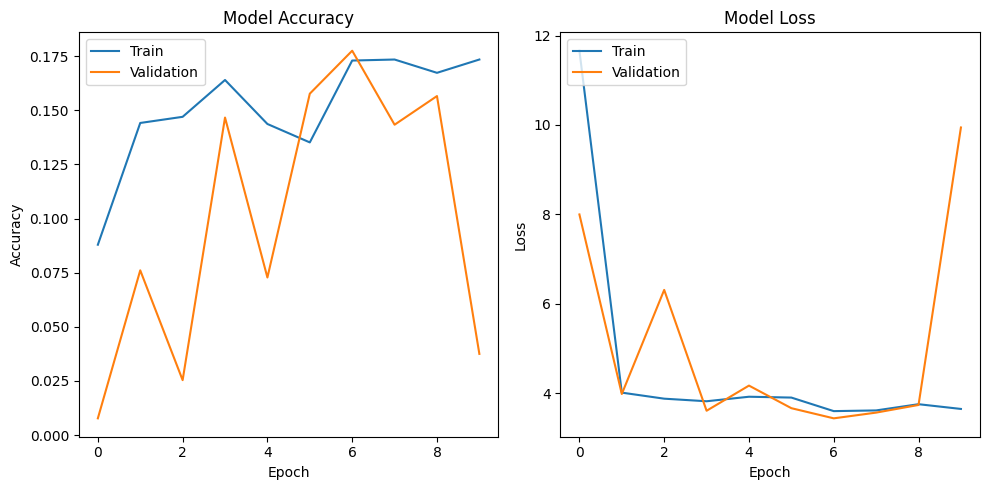

In [18]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])  # Now this line is active
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])  # And this line is active
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()


In [19]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Your pre-built and compiled model, assumed to be trained already.
predictions = alexnet.predict(test_x)
predicted_classes = np.argmax(predictions, axis=1)

# If you one-hot encoded the test labels for training,
# you need to reverse the one-hot encoding to get the original class indices.
actual_classes = np.argmax(test_y_onehot, axis=1)

# Inverse transform the predicted and actual class indices to their original names.
predicted_class_names = label_encoder.inverse_transform(predicted_classes)
actual_class_names = label_encoder.inverse_transform(actual_classes)

# Generate the classification report.
report = classification_report(actual_class_names, predicted_class_names, target_names=label_encoder.classes_)

print(report)


29/29 [==============================] - 1s 35ms/step
                           precision    recall  f1-score   support

         Alejandro_Toledo       0.00      0.00      0.00        11
             Alvaro_Uribe       0.00      0.00      0.00         9
          Amelie_Mauresmo       0.00      0.00      0.00         6
             Andre_Agassi       0.00      0.00      0.00        12
           Angelina_Jolie       0.00      0.00      0.00        10
             Ariel_Sharon       0.00      0.00      0.00        22
    Arnold_Schwarzenegger       0.00      0.00      0.00        13
     Atal_Bihari_Vajpayee       0.03      0.40      0.06         5
             Bill_Clinton       0.00      0.00      0.00        13
             Carlos_Menem       0.00      0.00      0.00         7
             Colin_Powell       0.06      0.04      0.05        79
            David_Beckham       0.00      0.00      0.00         9
          Donald_Rumsfeld       0.00      0.00      0.00        38
       

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
